In [ ]:
! pip install healpy
! pip install pixell

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
import math
from pixell import enmap, enplot, reproject, utils, curvedsky 
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.table as atpy
import astropy.units as u
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
from astropy.visualization import make_lupton_rgb
import random 
import os

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Объявляем пути до необходимых файлов

In [ ]:
maps_path = "drive/MyDrive/ACT"
path90 = os.path.join(maps_path, "act_dr5_f90.fits")
path150 = os.path.join(maps_path, "act_dr5_f150.fits")
path220 = os.path.join(maps_path, "act_dr5_f220.fits")
cluster_catalog = os.path.join(maps_path, "cluster-catalog.fits")

Функция для чтения части всех карт 

In [ ]:
def read_maps_box(ra_dp, dec_dp):
    ra_from, ra_to = np.deg2rad(ra_dp)
    dec_from, dec_to = np.deg2rad(dec_dp)
    box = [[dec_from,ra_from],[dec_to,ra_to]]
    imap90 = enmap.read_map(path90, box=box)
    imap150 = enmap.read_map(path150, box=box)
    imap220 = enmap.read_map(path220, box=box)
    return imap90, imap150, imap220

In [ ]:
def read_map_full(path):
    return enmap.read_map(path)

In [ ]:
imap90, imap150, imap220 = read_maps_box([100, 160], [-30, 20])

In [ ]:
imap90 = read_map_full(path90)

In [9]:
tab = atpy.Table().read(cluster_catalog)

Представляем каталог кластеров как pandas DataFrame

In [10]:
df = pd.DataFrame(dict(
    ra = list(tab['RADeg']),
    dec = list(tab['decDeg']),
    m500 = list(tab['M500c']),
    z = list(tab['redshift']),
    snr = list(tab['SNR']),
    y_coord = [0.0] * len(tab),
    x_coord = [0.0] * len(tab)
))

Выбираем только видимые галактики и вычисляем их координаты на карте

In [11]:
work_glx = df.loc[(df['snr'] > 8.5)]
for ind, glx in work_glx.iterrows():
    dec = glx['dec']
    ra = glx['ra']
    coords = np.deg2rad(np.array((dec,ra)))
    work_glx.at[ind, 'y_coord'], work_glx.at[ind, 'x_coord'] = enmap.sky2pix(imap90.shape, imap90.wcs, coords)

Функция для вывода только одного кластера

In [12]:
def show_patch(id, width=1, fsize=6, cmap=None):
    a = 1
    b = 2
    fig, axs = plt.subplots(1, 1, figsize=(fsize, fsize))    
    ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
    box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
    res = imap90[0].submap(box)
    axs.set_xlabel("m500={}, SNR={}".format(df.loc[id]['m500'], df.loc[id]['snr']))
    if cmap != None:
        axs.imshow(res, cmap=cmap)
    else:
        axs.imshow(res)

Функция для вывода нескольких кластеров в разной ориентации (вертикальной/горизантальной)

In [13]:
def show_patches(glxs, is_vertical=True, width=1, cmap=None, fsize=15):
    if is_vertical:
        fig, axs = plt.subplots(len(glxs), 1, figsize=(fsize, fsize))    
    else:
        fig, axs = plt.subplots(1, len(glxs), figsize=(fsize, fsize))    
    for i, id in enumerate(glxs):
        fig.tight_layout(pad=7)
        ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
        box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
        res = imap90[0].submap(box)
        axs[i].set_xlabel("m500={}, SNR={}".format(df.loc[id]['m500'], df.loc[id]['snr']))
        if cmap != None:
            axs[i].imshow(res, cmap=cmap)
        else:
            axs[i].imshow(res)

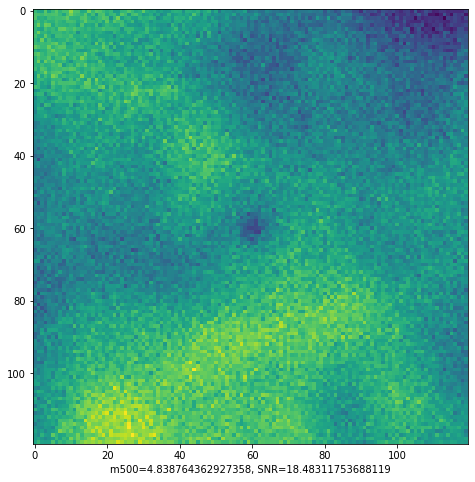

In [14]:
show_patch(128, fsize=8)

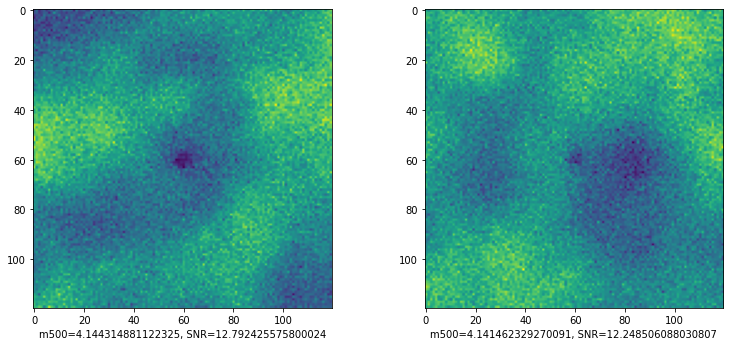

In [ ]:
show_patches([1993, 2000], False, fsize=12)

In [ ]:
def show_freq_patches(glxs, freqs=[(imap90, '90'), (imap150, '150'), 
                        (imap220, '220')], width=1, cmap="viridis", fsize=15):
    fig, axs = plt.subplots(len(glxs), len(freqs), figsize=(fsize, fsize))    
    for i, id in enumerate(glxs):
        fig.tight_layout(pad=7)
        ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
        box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
        for j, imap in enumerate(freqs):
            axs[i][j].set_title('Frequency {}'.format(imap[1]))
            axs[i][j].set_xlabel("m500={}, SNR={}".format(df.loc[id]['m500'], 
                                                          df.loc[id]['snr']),
                                                          fontsize=10)
            axs[i][j].imshow(imap[0][0].submap(box), cmap=cmap)

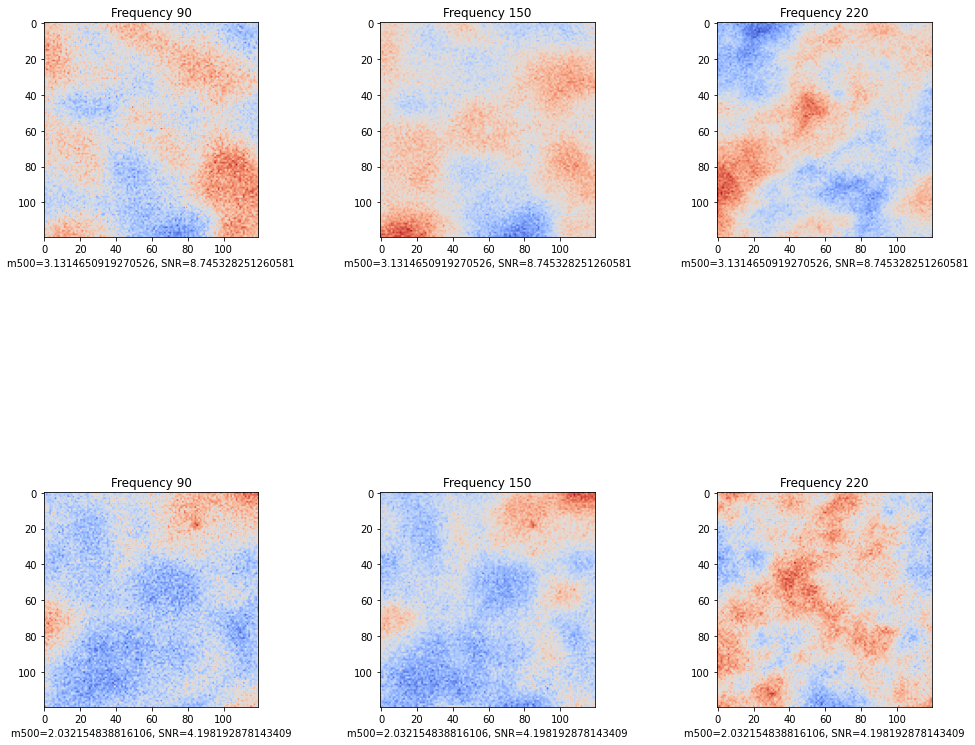

In [ ]:
show_freq_patches([2068, 2079], cmap='coolwarm')

Функция для генерации патчей(как просто картинок, так и масок сегментации)

In [32]:
def glx_in_box(glxs, curr_h, curr_w, box_height, box_width):
    return glxs.loc[(glxs['y_coord'] > curr_h)
             & (glxs['y_coord'] < curr_h + box_height)
             & (glxs['x_coord'] > curr_w)
             & (glxs['x_coord'] < curr_w + box_width)]

In [47]:
def init_axes(f):
    ax = plt.Axes(f, [0., 0., 1., 1.])
    ax.set_axis_off()
    return ax

In [35]:
def make_circle(row, coef, bias, x, y, curr_w, curr_h):
    radius = min(row['m500'] * coef[0] + row['z'] * coef[1] + bias, 5)
    circle = plt.Circle((math.floor(x) - curr_w, math.floor(y) - curr_h), 
               round(radius), color='white')
    return circle

In [45]:
def make_patches(imap, glxs, path='dataset', ground=False, mask=False):
    box_size = 100
    curr_h, curr_w, start_h, start_w = 0, 0, 0, 0
    coef = np.array([1.44509305, -0.16399278])
    bias = -2.1075201676682633
    img_counter = 0
    while (curr_h < imap.shape[1]):
        curr_w = start_w
        while (curr_w < imap.shape[2]):
            tmp = glx_in_box(glxs, curr_h, curr_w, box_size, box_size)
            if len(tmp) > 0:
                fig = plt.figure(frameon=False, figsize=(2, 2))
                ax = init_axes(fig)
                fig.add_axes(ax)
                res = imap[0][curr_h:curr_h+box_size, curr_w:curr_w + box_size]
                if mask:
                    res = res.clip(0, 1)
                for ind, row in tmp.iterrows():
                    if ground:
                        x, y = row['x_coord'], row['y_coord']
                        if not mask:
                            ax.scatter(math.floor(x) - curr_w, math.floor(y) - curr_h, color='red', s=1, lw=0)
                        if mask:
                            a_circle = make_circle(row, coef, bias, x, y, 
                                                   curr_w, curr_h)
                            ax.add_artist(a_circle)
                    min_el = np.amin(res)
                    ax.imshow(res, vmin=min_el, vmax=abs(min_el), cmap='gray')
                if not os.path.exists(os.path.join(maps_path, path)):
                    os.makedirs(os.path.join(maps_path, path))
                fig.savefig(os.path.join(maps_path, path, '{}_id_{}_90_fq.png'.format(img_counter, ind)),
                            dpi=50, pad_inches=0)
                img_counter += 1
                plt.close()
            curr_w += 80
        curr_h += 80

In [48]:
make_patches(imap90, work_glx, path='masks', ground=True, mask=True)